In [ ]:
import numpy as np
import torch
import torch.nn               as nn
import torch.distributions as tdist
import os
import sys
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.utils.spectral_norm as spectral_norm
from torch.utils.data         import Dataset, TensorDataset, DataLoader
from torchvision              import datasets
import time
from time import sleep
from tqdm import tqdm
from prettytable import PrettyTable

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/NashFPNs/TransportationNetworks/')
save_dir = './drive/MyDrive/NashFPNs/' # generated data should be saved in this path

device = "cuda"

capacity   = torch.tensor
context    = torch.tensor
action     = torch.tensor
edge       = torch.tensor
inference  = torch.tensor 
context    = torch.tensor

seed = 42
torch.manual_seed(seed)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Training Data

In [ ]:
# load data and split into training and testing set:
data_set = 'Eastern-Massachusetts'
save_dir = 'drive/MyDrive/NashFPNs/TrafficTrainingData/'
state_path = save_dir + data_set + '_training_data.pth'
state = torch.load(state_path)

In [ ]:
capacity        = state['capacity']
W               = state['W']
N               = state['N']
free_flow_time  = state['free_flow_time']
x_train         = state['x_train']
x_test          = state['x_test']
d_train         = state['d_train']
d_test          = state['d_test']
b               = state['origin_destination_pairs']

context_size    = d_train.shape[1]
n_train         = d_train.shape[0]
n_test          = d_test.shape[0]

n_ODpairs       = b.shape[1]
n_edges         = x_train.shape[1]
n_nodes         = b.shape[0]

In [ ]:
train_dataset   = TensorDataset(x_train, d_train)
test_dataset    = TensorDataset(x_test, d_test)

train_batch_size = 500
test_batch_size  = 500

train_loader  = DataLoader(dataset=train_dataset,  
                            batch_size=train_batch_size, shuffle=True) 
test_loader   = DataLoader(dataset=test_dataset,   
                            batch_size=test_batch_size,  shuffle=False) 

In [ ]:
norm_x_test = torch.norm(x_test)

In [ ]:
print('n_ODpairs = ', n_ODpairs, 'n_nodes = ', n_nodes, ', n_edges = ', n_edges, ', n_train = ', x_train.shape[0])

n_ODpairs =  1113 n_nodes =  74 , n_edges =  258 , n_train =  5000


## Create Neural Network Architecture

In [ ]:
inference = torch.tensor
latent_variable = torch.tensor
context = torch.tensor

class Traffix_Net(nn.Module):
    def __init__(self, N, b, context_size, alpha, device):
        super().__init__()
        
        self.b = b.to(device)
        self.alpha = alpha

        U,s,VT = torch.linalg.svd(N, full_matrices=False) 
        # truncate sing. values below 1e-5
        ind = s >= 1e-5 
        s = s[ind]
        U = U[:,ind]
        VT = VT[ind, :]
        self.V = VT.t().to(device)
        self.V_Sinv_UT = VT.t().matmul( torch.diag(1/s).matmul(U.t()) ).to(device)

        self.n_nodes    = N.shape[0]
        self.n_edges    = N.shape[1] 
        self.n_ODpairs  = b.shape[1] 

        self.F_fcs_d = nn.ModuleList([nn.Linear(context_size, 100), 
                                    nn.Linear(100, 100)])
        self.fc_final_d = nn.Linear(100, self.n_edges)

        self.F_fcs = nn.ModuleList([nn.Linear(self.n_edges, 100), 
                                    nn.Linear(100, 100)])
        self.fc_final = nn.Linear(100, self.n_edges)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)

        self.tanh = nn.Tanh()

        for fc in self.F_fcs: 
          torch.nn.init.zeros_(fc.weight)
        for fc in self.F_fcs_d: 
          torch.nn.init.zeros_(fc.weight)

        torch.nn.init.zeros_(self.fc_final.weight)
        torch.nn.init.zeros_(self.fc_final_d.weight)

    def device(self):
        return next(self.parameters()).data.device

    def project_C1(self, z: latent_variable) -> latent_variable: 
        return torch.clamp(z, min=0)

    def project_C2(self, z: latent_variable) -> latent_variable:
        Pz    = z - (self.V).matmul(self.V.t().matmul(z)) + self.V_Sinv_UT.matmul(self.b.unsqueeze(0))
        return Pz

    def F(self, x: action, d: context) -> action: 
      """
        Game Gradient Parameterization
          Inputs: 
            x = action with shape (batch_size x n_edges) 
            d = context with shape (batch_size x context_size)
      """

        Fd = d
        for fc in self.F_fcs_d:
          Fd = self.tanh(fc(Fd))
        Fd = self.leaky_relu(self.fc_final_d(Fd))
        
        Fx = x
        for fc in self.F_fcs: 
            Fx = self.tanh(fc(Fx)) 

        Fx = self.leaky_relu(self.fc_final(Fx))
        Fx = torch.clamp(Fx, min = -5e6, max=5e6) 
        
        return self.leaky_relu(Fx*Fd)
        

    def T(self, z: latent_variable, d: context) -> latent_variable: 
      """
        Davis-Yin Splitting described in Algorithm 3 
          Inputs: 
            z = action with shape (batch_size x n_edges x n_ODpairs) 
            d = context with shape (batch_size x context_size)
      """

        x = self.project_C1(z)
        v = torch.sum(x, dim=2)
        Fv = self.F(v,d)
        y = 2*x - z - self.alpha*Fv.unsqueeze(2)
        y = self.project_C2(y)
        z = z + y - x

        return z


    def S(self, z: latent_variable) -> inference:
      """
        Final layer that map from latent space to inference space. 
        Operations: project, sum across OD pairs, and clamp
          Inputs: 
            z = action with shape (batch_size x n_edges x n_ODpairs) 
          Output:
            v = action with shape (batch_size x n_edges)
      """

        z = self.project_C1(z)
        v = torch.sum(z, dim=2)
        return torch.clamp(v, max=1e6)

    def forward(self, d: context, eps=1.0e-2, max_depth=100, 
                depth_warning=False) -> inference: 

        with torch.no_grad():
            self.depth = 0.0

            z = torch.zeros((d.shape[0], self.n_edges, self.n_ODpairs), device=self.device())
            z_prev = z.clone()         
            
            all_samp_conv = False
            while not all_samp_conv and self.depth < max_depth:
                z_prev = z.clone()   
                z = self.T(z,d)
                diff_norm = torch.norm(z - z_prev, dim=1) 
                diff_norm = torch.norm( diff_norm, dim=1) 
                diff_norm = torch.max( diff_norm ) # take norm along the latter two dimensions then max
                self.depth += 1.0
                all_samp_conv = diff_norm <= eps
            
        if self.depth >= max_depth and depth_warning:
            print("\nWarning: Max Depth Reached - Break Forward Loop\n")

        attach_gradients = self.training
        if attach_gradients:
            z = self.T(z, d)
            return self.S(z)
        else:
            return self.S(z) 


  

In [ ]:
alpha = 1e-2
net = Traffix_Net(N, b, context_size, alpha, device)
net.to(device)

tensor([[1.3804e+03, 9.7330e+02, 9.6257e+02,  ..., 6.3508e-03, 2.3857e+03,
         1.9018e+03],
        [1.3804e+03, 9.7330e+02, 9.6257e+02,  ..., 6.3508e-03, 2.3857e+03,
         1.9018e+03],
        [1.3804e+03, 9.7330e+02, 9.6257e+02,  ..., 6.3508e-03, 2.3857e+03,
         1.9018e+03],
        ...,
        [1.3804e+03, 9.7330e+02, 9.6257e+02,  ..., 6.3508e-03, 2.3857e+03,
         1.9018e+03],
        [1.3804e+03, 9.7330e+02, 9.6257e+02,  ..., 6.3508e-03, 2.3857e+03,
         1.9018e+03],
        [1.3804e+03, 9.7330e+02, 9.6257e+02,  ..., 6.3508e-03, 2.3857e+03,
         1.9018e+03]], device='cuda:0', grad_fn=<ClampBackward>)

In [ ]:
def get_trafix_score(x_pred: action, x_true: action, eps=5.0e-3, 
                     tol=1.0e-3) -> float:
  err           = torch.abs(x_pred - x_true)
  denom         = torch.abs(x_true) + tol
  rel_err       = err.div(denom)
  acc_preds     = rel_err < eps  
  num_samples   = x_true.shape[0]
  num_preds     = x_true.shape[1]
  trafix_score  = 100.0 * sum(sum(acc_preds)) / (num_samples * num_preds) 
  return trafix_score

def get_testing_stats(net, test_loader, criterion, n_edges, eps, depth, eps_traffix_score, device=device):
    test_loss = 0
    correct = 0
    rel_err = 0
    rel_err_dim0 = torch.zeros(n_edges, device=device)

    net.eval()
    with torch.no_grad():
        for _, (x_true, d_true) in enumerate(test_loader):
          
          x_true, d_true = x_true.to(device), d_true.to(device)
          batch_size = x_true.shape[0]

          x_pred = net(d_true, eps=eps, max_depth=depth) 

          test_loss += batch_size * criterion(x_pred, x_true)

          rel_err += torch.norm(x_pred - x_true)**2
          rel_err_dim0 += torch.norm(x_pred - x_true, dim=0)**2

    test_loss  /= len(test_loader.dataset)
    rel_err    = torch.sqrt(rel_err) / norm_x_test

    # rel_err_dim0 = torch.sqrt(rel_err_dim0) / norm_x_test_dim0
    # ind = rel_err_dim0 < eps_traffic_score
    # traffic_score = 100*(sum(ind)/n_edges)
    traffix_score = get_trafix_score(x_pred, x_true, eps=eps_traffix_score) 
    

    net.train()

    return test_loss, rel_err, traffix_score


In [ ]:
def model_params(net):
    table = PrettyTable(["Network Component", "# Parameters"])
    num_params = 0
    for name, parameter in net.named_parameters():
        if not parameter.requires_grad:
            continue
        table.add_row([name, parameter.numel()])
        num_params += parameter.numel()
    table.add_row(['TOTAL', num_params])
    return table

print(net)
print(model_params(net))

Traffix_Net(
  (F_fcs_d): ModuleList(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final_d): Linear(in_features=100, out_features=258, bias=True)
  (F_fcs): ModuleList(
    (0): Linear(in_features=258, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final): Linear(in_features=100, out_features=258, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (tanh): Tanh()
)
+-------------------+--------------+
| Network Component | # Parameters |
+-------------------+--------------+
|  F_fcs_d.0.weight |     1000     |
|   F_fcs_d.0.bias  |     100      |
|  F_fcs_d.1.weight |    10000     |
|   F_fcs_d.1.bias  |     100      |
| fc_final_d.weight |    25800     |
|  fc_final_d.bias  |     258      |
|   F_fcs.0.weight  |    25800     |
|    F_fcs.0.bias   |     100      |
|   F_fcs.1.weight  |    10000     |
|    F_fcs.1.bias   | 

## Set up Training

In [ ]:
# training setup
learning_rate = 1e-3
optimizer     = optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler  = optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1)
eps           = 1.0e-4  # Used for stopping criterion in implicit-depth
criterion     = nn.MSELoss()
max_depth     = 50

train_loss_hist     = []
test_loss_hist      = []
traffix_score_hist  = []
rel_err_hist        = []
best_traffix_score  = 0.0

max_epochs = int(2e2)
x_test = x_test.to(device)
d_test = d_test.to(device)

# start_time_epoch = time.time() # timer for display execution time per epoch multiple
fmt        = '[{:4d}/{:4d}]: train loss = {:7.3e} | test loss = {:7.3e} | traffix score = {:7.3f}% | rel error = {:7.3e} ' 
fmt       += 'depth = {:5.1f} | lr = {:5.1e} | eps = {:5.1e} | time = {:5.1e}'
print(net)                 # display Tnet configuration
 
print('\nTraining G-FPN')
for epoch in range(max_epochs): 

  net.train()
  sleep(0.3)  # slows progress bar so it won't print on multiple lines
  loss_ave        = 0.0
  epoch_start_time = time.time()
  tot = len(train_loader)
  with tqdm(total=tot, unit=" batch", leave=False, ascii=True) as tepoch:

    tepoch.set_description("[{:3d}/{:3d}]".format(epoch+1, max_epochs))

    for _, (x_true, d_true) in enumerate(train_loader):

      x_true, d_true = x_true.to(device), d_true.to(device)

      optimizer.zero_grad()
      x_pred = net(d_true, eps=eps, max_depth=max_depth) 

      loss = criterion(x_pred, x_true)
      local_batch_size = x_true.shape[0]
      loss_ave += local_batch_size * loss

      loss.backward()
      optimizer.step()

      tepoch.update(1)
      tepoch.set_postfix(train_loss="{:5.2e}".format(loss.detach().cpu().numpy()),
                          depth="{:5.1f}".format(net.depth))

  lr_scheduler.step()
  epoch_end_time = time.time()
  time_epoch = epoch_end_time - epoch_start_time
  loss_ave = loss_ave/n_train
  train_loss_hist.append(loss_ave)

  eps_traffix_score = 5e-3
  test_loss, rel_err_test, traffix_score = get_testing_stats(net, test_loader, criterion, n_edges, eps, max_depth, eps_traffix_score)

  traffix_score_hist.append(traffix_score)
  test_loss_hist.append(test_loss)
  rel_err_hist.append(rel_err_test)

 
  print(fmt.format(epoch+1, max_epochs, loss.item(), test_loss, traffix_score, rel_err_test, net.depth, 
                    optimizer.param_groups[0]['lr'], eps, time_epoch))
  
  # ---------------------------------------------------------------------
  # Save weights
  # ---------------------------------------------------------------------
  if traffix_score > best_traffix_score:
    best_traffix_score = traffix_score
    state = {
        'test_loss_hist': test_loss_hist,
        'traffix_score_hist': traffix_score_hist,
        'rel_err_hist': rel_err_hist,
        'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler,
    }
    file_name = save_dir + 'FinalResults/' + data_set + '_weights.pth'
    torch.save(state, file_name)
    print('Model weights saved to ' + file_name)

  # ---------------------------------------------------------------------
  # Save history at last epoch
  # ---------------------------------------------------------------------

  if epoch+1 == max_epochs:
      state = {
        'test_loss_hist': test_loss_hist,
        'traffix_score_hist': traffix_score_hist,
        'rel_err_hist': rel_err_hist,
        'lr_scheduler': lr_scheduler,
        'eps': eps,
      }
      file_name = save_dir + 'FinalResults/' + data_set + '_history.pth'
      torch.save(state, file_name)
      print('Training history saved to ' + file_name)

Traffix_Net(
  (F_fcs_d): ModuleList(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final_d): Linear(in_features=100, out_features=258, bias=True)
  (F_fcs): ModuleList(
    (0): Linear(in_features=258, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final): Linear(in_features=100, out_features=258, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (tanh): Tanh()
)

Training G-FPN


[   1/ 200]: train loss = 1.329e+02 | test loss = 1.353e+02 | traffix score =  90.326% | rel error = 6.160e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[   2/ 200]: train loss = 1.241e+02 | test loss = 1.164e+02 | traffix score =  92.064% | rel error = 5.715e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[   3/ 200]: train loss = 7.295e+01 | test loss = 6.973e+01 | traffix score =  92.015% | rel error = 4.422e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[   4/ 200]: train loss = 6.072e+01 | test loss = 6.013e+01 | traffix score =  92.267% | rel error = 4.107e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[   5/ 200]: train loss = 5.181e+01 | test loss = 5.046e+01 | traffix score =  93.856% | rel error = 3.762e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[   6/ 200]: train loss = 4.008e+01 | test loss = 3.604e+01 | traffix score =  95.009% | rel error = 3.179e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[   7/ 200]: train loss = 4.646e+01 | test loss = 4.231e+01 | traffix score =  94.284% | rel error = 3.445e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[   8/ 200]: train loss = 4.206e+01 | test loss = 4.096e+01 | traffix score =  94.686% | rel error = 3.389e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[   9/ 200]: train loss = 3.454e+01 | test loss = 3.247e+01 | traffix score =  95.320% | rel error = 3.017e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  10/ 200]: train loss = 3.001e+01 | test loss = 2.979e+01 | traffix score =  95.553% | rel error = 2.891e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  11/ 200]: train loss = 2.888e+01 | test loss = 2.793e+01 | traffix score =  95.546% | rel error = 2.799e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  12/ 200]: train loss = 2.853e+01 | test loss = 2.626e+01 | traffix score =  95.810% | rel error = 2.714e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  13/ 200]: train loss = 2.517e+01 | test loss = 2.592e+01 | traffix score =  95.908% | rel error = 2.696e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  14/ 200]: train loss = 2.663e+01 | test loss = 2.543e+01 | traffix score =  95.891% | rel error = 2.670e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  15/ 200]: train loss = 2.607e+01 | test loss = 2.431e+01 | traffix score =  95.943% | rel error = 2.611e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  16/ 200]: train loss = 2.507e+01 | test loss = 2.310e+01 | traffix score =  96.033% | rel error = 2.545e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  17/ 200]: train loss = 2.132e+01 | test loss = 2.151e+01 | traffix score =  96.180% | rel error = 2.456e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  18/ 200]: train loss = 2.061e+01 | test loss = 2.109e+01 | traffix score =  96.161% | rel error = 2.432e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  19/ 200]: train loss = 2.063e+01 | test loss = 2.056e+01 | traffix score =  96.222% | rel error = 2.401e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  20/ 200]: train loss = 1.986e+01 | test loss = 2.027e+01 | traffix score =  96.234% | rel error = 2.385e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  21/ 200]: train loss = 1.919e+01 | test loss = 1.940e+01 | traffix score =  96.298% | rel error = 2.332e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  22/ 200]: train loss = 1.721e+01 | test loss = 1.870e+01 | traffix score =  96.390% | rel error = 2.290e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  23/ 200]: train loss = 1.832e+01 | test loss = 1.877e+01 | traffix score =  96.412% | rel error = 2.294e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  24/ 200]: train loss = 1.897e+01 | test loss = 1.777e+01 | traffix score =  96.473% | rel error = 2.232e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  25/ 200]: train loss = 1.858e+01 | test loss = 1.751e+01 | traffix score =  96.509% | rel error = 2.216e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  26/ 200]: train loss = 1.716e+01 | test loss = 1.677e+01 | traffix score =  96.591% | rel error = 2.169e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  27/ 200]: train loss = 1.635e+01 | test loss = 1.676e+01 | traffix score =  96.627% | rel error = 2.168e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  28/ 200]: train loss = 1.658e+01 | test loss = 1.598e+01 | traffix score =  96.665% | rel error = 2.117e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  29/ 200]: train loss = 1.690e+01 | test loss = 1.532e+01 | traffix score =  96.712% | rel error = 2.073e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  30/ 200]: train loss = 1.505e+01 | test loss = 1.495e+01 | traffix score =  96.753% | rel error = 2.047e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  31/ 200]: train loss = 1.449e+01 | test loss = 1.410e+01 | traffix score =  96.806% | rel error = 1.989e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  32/ 200]: train loss = 1.414e+01 | test loss = 1.366e+01 | traffix score =  96.816% | rel error = 1.957e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  33/ 200]: train loss = 1.364e+01 | test loss = 1.281e+01 | traffix score =  96.864% | rel error = 1.895e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  34/ 200]: train loss = 1.197e+01 | test loss = 1.218e+01 | traffix score =  96.962% | rel error = 1.848e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  35/ 200]: train loss = 1.133e+01 | test loss = 1.132e+01 | traffix score =  97.069% | rel error = 1.782e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  36/ 200]: train loss = 1.003e+01 | test loss = 1.053e+01 | traffix score =  97.156% | rel error = 1.718e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  37/ 200]: train loss = 1.050e+01 | test loss = 1.012e+01 | traffix score =  97.174% | rel error = 1.684e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  38/ 200]: train loss = 8.871e+00 | test loss = 9.079e+00 | traffix score =  97.223% | rel error = 1.596e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  39/ 200]: train loss = 8.603e+00 | test loss = 8.216e+00 | traffix score =  97.335% | rel error = 1.518e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  40/ 200]: train loss = 7.718e+00 | test loss = 7.444e+00 | traffix score =  97.285% | rel error = 1.445e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  41/ 200]: train loss = 7.724e+00 | test loss = 6.916e+00 | traffix score =  97.450% | rel error = 1.393e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  42/ 200]: train loss = 7.488e+00 | test loss = 6.674e+00 | traffix score =  97.388% | rel error = 1.368e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  43/ 200]: train loss = 6.377e+00 | test loss = 6.145e+00 | traffix score =  97.471% | rel error = 1.313e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  44/ 200]: train loss = 6.403e+00 | test loss = 5.888e+00 | traffix score =  97.612% | rel error = 1.285e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  45/ 200]: train loss = 5.595e+00 | test loss = 5.707e+00 | traffix score =  97.554% | rel error = 1.265e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  46/ 200]: train loss = 5.892e+00 | test loss = 5.522e+00 | traffix score =  97.518% | rel error = 1.244e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  47/ 200]: train loss = 6.499e+00 | test loss = 5.364e+00 | traffix score =  97.533% | rel error = 1.227e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  48/ 200]: train loss = 5.428e+00 | test loss = 5.208e+00 | traffix score =  97.457% | rel error = 1.209e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  49/ 200]: train loss = 5.563e+00 | test loss = 5.151e+00 | traffix score =  97.526% | rel error = 1.202e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  50/ 200]: train loss = 4.861e+00 | test loss = 4.939e+00 | traffix score =  97.568% | rel error = 1.177e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  51/ 200]: train loss = 4.449e+00 | test loss = 4.733e+00 | traffix score =  97.581% | rel error = 1.152e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  52/ 200]: train loss = 4.794e+00 | test loss = 4.570e+00 | traffix score =  97.598% | rel error = 1.132e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  53/ 200]: train loss = 4.609e+00 | test loss = 4.458e+00 | traffix score =  97.539% | rel error = 1.118e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  54/ 200]: train loss = 4.443e+00 | test loss = 4.365e+00 | traffix score =  97.608% | rel error = 1.106e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  55/ 200]: train loss = 3.932e+00 | test loss = 4.297e+00 | traffix score =  97.676% | rel error = 1.098e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  56/ 200]: train loss = 4.421e+00 | test loss = 4.181e+00 | traffix score =  97.637% | rel error = 1.083e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  57/ 200]: train loss = 4.205e+00 | test loss = 4.060e+00 | traffix score =  97.623% | rel error = 1.067e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  58/ 200]: train loss = 3.999e+00 | test loss = 3.950e+00 | traffix score =  97.645% | rel error = 1.052e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  59/ 200]: train loss = 4.265e+00 | test loss = 3.860e+00 | traffix score =  97.662% | rel error = 1.040e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  60/ 200]: train loss = 4.326e+00 | test loss = 3.810e+00 | traffix score =  97.574% | rel error = 1.034e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  61/ 200]: train loss = 3.352e+00 | test loss = 3.689e+00 | traffix score =  97.619% | rel error = 1.017e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  62/ 200]: train loss = 3.385e+00 | test loss = 3.607e+00 | traffix score =  97.649% | rel error = 1.006e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  63/ 200]: train loss = 2.901e+00 | test loss = 3.562e+00 | traffix score =  97.619% | rel error = 9.994e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  64/ 200]: train loss = 3.892e+00 | test loss = 3.448e+00 | traffix score =  97.604% | rel error = 9.834e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  65/ 200]: train loss = 3.164e+00 | test loss = 3.340e+00 | traffix score =  97.668% | rel error = 9.679e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  66/ 200]: train loss = 3.340e+00 | test loss = 3.305e+00 | traffix score =  97.678% | rel error = 9.628e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  67/ 200]: train loss = 3.519e+00 | test loss = 3.301e+00 | traffix score =  97.691% | rel error = 9.622e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  68/ 200]: train loss = 3.411e+00 | test loss = 3.155e+00 | traffix score =  97.705% | rel error = 9.407e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  69/ 200]: train loss = 3.431e+00 | test loss = 3.200e+00 | traffix score =  97.679% | rel error = 9.473e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  70/ 200]: train loss = 2.614e+00 | test loss = 3.052e+00 | traffix score =  97.674% | rel error = 9.251e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  71/ 200]: train loss = 3.222e+00 | test loss = 3.032e+00 | traffix score =  97.726% | rel error = 9.221e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  72/ 200]: train loss = 2.618e+00 | test loss = 3.037e+00 | traffix score =  97.626% | rel error = 9.228e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  73/ 200]: train loss = 2.651e+00 | test loss = 2.860e+00 | traffix score =  97.557% | rel error = 8.955e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  74/ 200]: train loss = 3.149e+00 | test loss = 2.784e+00 | traffix score =  97.561% | rel error = 8.837e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  75/ 200]: train loss = 3.099e+00 | test loss = 2.834e+00 | traffix score =  97.587% | rel error = 8.915e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  76/ 200]: train loss = 2.796e+00 | test loss = 2.666e+00 | traffix score =  97.556% | rel error = 8.647e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  77/ 200]: train loss = 2.786e+00 | test loss = 2.701e+00 | traffix score =  97.604% | rel error = 8.704e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  78/ 200]: train loss = 2.586e+00 | test loss = 2.678e+00 | traffix score =  97.788% | rel error = 8.666e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  79/ 200]: train loss = 2.668e+00 | test loss = 2.581e+00 | traffix score =  97.713% | rel error = 8.508e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  80/ 200]: train loss = 2.053e+00 | test loss = 2.429e+00 | traffix score =  97.773% | rel error = 8.254e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  81/ 200]: train loss = 2.497e+00 | test loss = 2.750e+00 | traffix score =  97.741% | rel error = 8.782e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  82/ 200]: train loss = 2.115e+00 | test loss = 2.327e+00 | traffix score =  97.790% | rel error = 8.078e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  83/ 200]: train loss = 2.078e+00 | test loss = 2.307e+00 | traffix score =  97.803% | rel error = 8.043e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  84/ 200]: train loss = 1.756e+00 | test loss = 2.232e+00 | traffix score =  97.838% | rel error = 7.912e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  85/ 200]: train loss = 2.100e+00 | test loss = 2.202e+00 | traffix score =  97.816% | rel error = 7.858e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  86/ 200]: train loss = 2.342e+00 | test loss = 2.175e+00 | traffix score =  97.809% | rel error = 7.811e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  87/ 200]: train loss = 1.967e+00 | test loss = 2.110e+00 | traffix score =  97.777% | rel error = 7.692e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  88/ 200]: train loss = 2.178e+00 | test loss = 2.098e+00 | traffix score =  97.809% | rel error = 7.670e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  89/ 200]: train loss = 2.155e+00 | test loss = 2.087e+00 | traffix score =  97.733% | rel error = 7.651e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  90/ 200]: train loss = 1.808e+00 | test loss = 2.042e+00 | traffix score =  97.854% | rel error = 7.567e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[  91/ 200]: train loss = 1.796e+00 | test loss = 2.021e+00 | traffix score =  97.785% | rel error = 7.528e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  92/ 200]: train loss = 1.634e+00 | test loss = 1.951e+00 | traffix score =  97.744% | rel error = 7.398e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  93/ 200]: train loss = 2.279e+00 | test loss = 1.899e+00 | traffix score =  97.813% | rel error = 7.299e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  94/ 200]: train loss = 2.297e+00 | test loss = 1.927e+00 | traffix score =  97.798% | rel error = 7.352e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  95/ 200]: train loss = 2.264e+00 | test loss = 1.923e+00 | traffix score =  97.805% | rel error = 7.345e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  96/ 200]: train loss = 1.874e+00 | test loss = 1.819e+00 | traffix score =  97.702% | rel error = 7.142e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  97/ 200]: train loss = 1.523e+00 | test loss = 1.810e+00 | traffix score =  97.718% | rel error = 7.124e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  98/ 200]: train loss = 1.997e+00 | test loss = 1.765e+00 | traffix score =  97.800% | rel error = 7.035e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[  99/ 200]: train loss = 1.870e+00 | test loss = 1.741e+00 | traffix score =  97.823% | rel error = 6.988e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 100/ 200]: train loss = 1.648e+00 | test loss = 1.750e+00 | traffix score =  97.789% | rel error = 7.005e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 101/ 200]: train loss = 1.843e+00 | test loss = 1.705e+00 | traffix score =  97.881% | rel error = 6.914e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[ 102/ 200]: train loss = 1.786e+00 | test loss = 1.720e+00 | traffix score =  97.822% | rel error = 6.944e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 103/ 200]: train loss = 1.795e+00 | test loss = 1.618e+00 | traffix score =  97.753% | rel error = 6.737e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 104/ 200]: train loss = 1.318e+00 | test loss = 1.603e+00 | traffix score =  97.709% | rel error = 6.704e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 105/ 200]: train loss = 1.431e+00 | test loss = 1.614e+00 | traffix score =  97.778% | rel error = 6.727e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 106/ 200]: train loss = 2.019e+00 | test loss = 1.558e+00 | traffix score =  97.870% | rel error = 6.611e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 107/ 200]: train loss = 1.735e+00 | test loss = 1.557e+00 | traffix score =  97.905% | rel error = 6.609e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[ 108/ 200]: train loss = 1.547e+00 | test loss = 1.571e+00 | traffix score =  97.765% | rel error = 6.639e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 109/ 200]: train loss = 1.340e+00 | test loss = 1.537e+00 | traffix score =  97.750% | rel error = 6.566e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 110/ 200]: train loss = 1.709e+00 | test loss = 1.459e+00 | traffix score =  97.926% | rel error = 6.398e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[ 111/ 200]: train loss = 1.535e+00 | test loss = 1.484e+00 | traffix score =  97.738% | rel error = 6.451e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 112/ 200]: train loss = 1.233e+00 | test loss = 1.454e+00 | traffix score =  97.805% | rel error = 6.386e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 113/ 200]: train loss = 1.677e+00 | test loss = 1.632e+00 | traffix score =  97.792% | rel error = 6.766e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 114/ 200]: train loss = 1.640e+00 | test loss = 1.676e+00 | traffix score =  97.684% | rel error = 6.855e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 115/ 200]: train loss = 1.162e+00 | test loss = 1.502e+00 | traffix score =  97.733% | rel error = 6.490e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 116/ 200]: train loss = 1.300e+00 | test loss = 1.456e+00 | traffix score =  97.751% | rel error = 6.389e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 117/ 200]: train loss = 1.614e+00 | test loss = 1.412e+00 | traffix score =  97.771% | rel error = 6.294e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 118/ 200]: train loss = 1.278e+00 | test loss = 1.363e+00 | traffix score =  97.772% | rel error = 6.184e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 119/ 200]: train loss = 1.034e+00 | test loss = 1.333e+00 | traffix score =  97.840% | rel error = 6.113e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 120/ 200]: train loss = 1.193e+00 | test loss = 1.360e+00 | traffix score =  97.721% | rel error = 6.175e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 121/ 200]: train loss = 9.690e-01 | test loss = 1.370e+00 | traffix score =  97.764% | rel error = 6.199e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 122/ 200]: train loss = 1.499e+00 | test loss = 1.404e+00 | traffix score =  97.755% | rel error = 6.275e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 123/ 200]: train loss = 1.187e+00 | test loss = 1.302e+00 | traffix score =  97.749% | rel error = 6.042e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 124/ 200]: train loss = 1.063e+00 | test loss = 1.354e+00 | traffix score =  97.725% | rel error = 6.163e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 125/ 200]: train loss = 1.216e+00 | test loss = 1.257e+00 | traffix score =  97.850% | rel error = 5.937e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 126/ 200]: train loss = 1.088e+00 | test loss = 1.331e+00 | traffix score =  97.732% | rel error = 6.109e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 127/ 200]: train loss = 9.149e-01 | test loss = 1.253e+00 | traffix score =  97.847% | rel error = 5.927e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 128/ 200]: train loss = 8.835e-01 | test loss = 1.254e+00 | traffix score =  97.813% | rel error = 5.931e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 129/ 200]: train loss = 1.448e+00 | test loss = 1.220e+00 | traffix score =  97.857% | rel error = 5.849e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 130/ 200]: train loss = 1.175e+00 | test loss = 1.326e+00 | traffix score =  97.884% | rel error = 6.098e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 131/ 200]: train loss = 1.011e+00 | test loss = 1.226e+00 | traffix score =  97.733% | rel error = 5.864e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 132/ 200]: train loss = 1.020e+00 | test loss = 1.247e+00 | traffix score =  97.778% | rel error = 5.914e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 133/ 200]: train loss = 1.146e+00 | test loss = 1.157e+00 | traffix score =  97.798% | rel error = 5.697e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 134/ 200]: train loss = 1.042e+00 | test loss = 1.148e+00 | traffix score =  97.884% | rel error = 5.674e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 135/ 200]: train loss = 1.004e+00 | test loss = 1.335e+00 | traffix score =  97.702% | rel error = 6.120e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 136/ 200]: train loss = 1.142e+00 | test loss = 1.271e+00 | traffix score =  97.881% | rel error = 5.970e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 137/ 200]: train loss = 7.476e-01 | test loss = 1.182e+00 | traffix score =  97.806% | rel error = 5.757e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 138/ 200]: train loss = 8.776e-01 | test loss = 1.140e+00 | traffix score =  97.751% | rel error = 5.654e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 139/ 200]: train loss = 1.173e+00 | test loss = 1.257e+00 | traffix score =  97.770% | rel error = 5.936e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 140/ 200]: train loss = 8.729e-01 | test loss = 1.110e+00 | traffix score =  97.791% | rel error = 5.580e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 141/ 200]: train loss = 1.114e+00 | test loss = 1.093e+00 | traffix score =  97.825% | rel error = 5.537e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 142/ 200]: train loss = 1.042e+00 | test loss = 1.109e+00 | traffix score =  97.764% | rel error = 5.578e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 143/ 200]: train loss = 1.021e+00 | test loss = 1.175e+00 | traffix score =  97.756% | rel error = 5.741e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 144/ 200]: train loss = 9.112e-01 | test loss = 1.199e+00 | traffix score =  97.803% | rel error = 5.800e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 145/ 200]: train loss = 9.562e-01 | test loss = 1.149e+00 | traffix score =  97.842% | rel error = 5.676e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 146/ 200]: train loss = 8.053e-01 | test loss = 1.049e+00 | traffix score =  97.865% | rel error = 5.424e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 147/ 200]: train loss = 9.765e-01 | test loss = 1.635e+00 | traffix score =  97.692% | rel error = 6.771e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 148/ 200]: train loss = 8.747e-01 | test loss = 1.287e+00 | traffix score =  97.920% | rel error = 6.007e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 149/ 200]: train loss = 1.085e+00 | test loss = 1.251e+00 | traffix score =  97.824% | rel error = 5.923e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 150/ 200]: train loss = 1.763e+00 | test loss = 1.284e+00 | traffix score =  97.818% | rel error = 6.000e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 151/ 200]: train loss = 8.493e-01 | test loss = 1.053e+00 | traffix score =  97.667% | rel error = 5.435e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 152/ 200]: train loss = 1.007e+00 | test loss = 1.602e+00 | traffix score =  97.753% | rel error = 6.703e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 153/ 200]: train loss = 2.191e+00 | test loss = 1.700e+00 | traffix score =  97.695% | rel error = 6.906e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 154/ 200]: train loss = 1.112e+00 | test loss = 1.124e+00 | traffix score =  97.732% | rel error = 5.616e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 155/ 200]: train loss = 7.531e-01 | test loss = 1.107e+00 | traffix score =  97.767% | rel error = 5.571e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 156/ 200]: train loss = 1.010e+00 | test loss = 1.069e+00 | traffix score =  97.836% | rel error = 5.475e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 157/ 200]: train loss = 1.099e+00 | test loss = 1.013e+00 | traffix score =  97.902% | rel error = 5.331e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 158/ 200]: train loss = 8.903e-01 | test loss = 1.058e+00 | traffix score =  97.794% | rel error = 5.446e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 159/ 200]: train loss = 8.552e-01 | test loss = 1.023e+00 | traffix score =  97.690% | rel error = 5.355e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 160/ 200]: train loss = 8.732e-01 | test loss = 1.173e+00 | traffix score =  97.778% | rel error = 5.735e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 161/ 200]: train loss = 6.446e-01 | test loss = 9.842e-01 | traffix score =  97.798% | rel error = 5.254e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 162/ 200]: train loss = 9.723e-01 | test loss = 1.011e+00 | traffix score =  97.942% | rel error = 5.324e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_weights.pth


[ 163/ 200]: train loss = 7.453e-01 | test loss = 1.062e+00 | traffix score =  97.856% | rel error = 5.457e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 164/ 200]: train loss = 1.032e+00 | test loss = 9.408e-01 | traffix score =  97.747% | rel error = 5.137e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 165/ 200]: train loss = 9.780e-01 | test loss = 9.785e-01 | traffix score =  97.733% | rel error = 5.239e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 166/ 200]: train loss = 9.968e-01 | test loss = 9.607e-01 | traffix score =  97.751% | rel error = 5.191e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 167/ 200]: train loss = 7.722e-01 | test loss = 1.028e+00 | traffix score =  97.835% | rel error = 5.369e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 168/ 200]: train loss = 9.534e-01 | test loss = 9.182e-01 | traffix score =  97.778% | rel error = 5.075e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 169/ 200]: train loss = 8.814e-01 | test loss = 9.225e-01 | traffix score =  97.861% | rel error = 5.086e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 170/ 200]: train loss = 8.734e-01 | test loss = 1.005e+00 | traffix score =  97.816% | rel error = 5.310e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 171/ 200]: train loss = 7.055e-01 | test loss = 1.049e+00 | traffix score =  97.805% | rel error = 5.424e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 172/ 200]: train loss = 1.015e+00 | test loss = 9.744e-01 | traffix score =  97.762% | rel error = 5.227e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 173/ 200]: train loss = 7.367e-01 | test loss = 9.121e-01 | traffix score =  97.730% | rel error = 5.058e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 174/ 200]: train loss = 6.985e-01 | test loss = 9.225e-01 | traffix score =  97.898% | rel error = 5.086e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 175/ 200]: train loss = 6.476e-01 | test loss = 8.950e-01 | traffix score =  97.745% | rel error = 5.010e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 176/ 200]: train loss = 7.861e-01 | test loss = 8.706e-01 | traffix score =  97.850% | rel error = 4.941e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 177/ 200]: train loss = 4.819e-01 | test loss = 1.164e+00 | traffix score =  97.816% | rel error = 5.713e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 178/ 200]: train loss = 9.488e-01 | test loss = 8.573e-01 | traffix score =  97.808% | rel error = 4.903e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 179/ 200]: train loss = 9.510e-01 | test loss = 9.353e-01 | traffix score =  97.873% | rel error = 5.122e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 180/ 200]: train loss = 7.667e-01 | test loss = 9.404e-01 | traffix score =  97.691% | rel error = 5.135e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 181/ 200]: train loss = 6.041e-01 | test loss = 8.892e-01 | traffix score =  97.781% | rel error = 4.994e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 182/ 200]: train loss = 5.600e-01 | test loss = 8.811e-01 | traffix score =  97.871% | rel error = 4.971e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 183/ 200]: train loss = 7.555e-01 | test loss = 8.761e-01 | traffix score =  97.774% | rel error = 4.957e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 184/ 200]: train loss = 8.286e-01 | test loss = 8.268e-01 | traffix score =  97.871% | rel error = 4.815e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 185/ 200]: train loss = 6.867e-01 | test loss = 8.304e-01 | traffix score =  97.849% | rel error = 4.826e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 186/ 200]: train loss = 5.623e-01 | test loss = 8.558e-01 | traffix score =  97.753% | rel error = 4.899e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 187/ 200]: train loss = 7.313e-01 | test loss = 7.960e-01 | traffix score =  97.868% | rel error = 4.725e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 188/ 200]: train loss = 6.643e-01 | test loss = 8.481e-01 | traffix score =  97.904% | rel error = 4.877e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 189/ 200]: train loss = 7.074e-01 | test loss = 8.798e-01 | traffix score =  97.853% | rel error = 4.967e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 190/ 200]: train loss = 5.249e-01 | test loss = 8.185e-01 | traffix score =  97.907% | rel error = 4.791e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 191/ 200]: train loss = 7.890e-01 | test loss = 8.403e-01 | traffix score =  97.747% | rel error = 4.854e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 192/ 200]: train loss = 5.675e-01 | test loss = 8.908e-01 | traffix score =  97.753% | rel error = 4.998e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 193/ 200]: train loss = 7.623e-01 | test loss = 7.878e-01 | traffix score =  97.816% | rel error = 4.700e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 194/ 200]: train loss = 5.100e-01 | test loss = 7.747e-01 | traffix score =  97.841% | rel error = 4.661e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 195/ 200]: train loss = 5.344e-01 | test loss = 8.193e-01 | traffix score =  97.878% | rel error = 4.793e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 196/ 200]: train loss = 7.311e-01 | test loss = 8.764e-01 | traffix score =  97.936% | rel error = 4.958e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 197/ 200]: train loss = 5.833e-01 | test loss = 8.481e-01 | traffix score =  97.716% | rel error = 4.877e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 198/ 200]: train loss = 6.182e-01 | test loss = 7.816e-01 | traffix score =  97.872% | rel error = 4.682e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 199/ 200]: train loss = 6.215e-01 | test loss = 7.905e-01 | traffix score =  97.924% | rel error = 4.709e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01


[ 200/ 200]: train loss = 5.847e-01 | test loss = 7.870e-01 | traffix score =  97.802% | rel error = 4.698e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 2.9e+01
Training history saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Eastern-Massachusetts_history.pth


## Plot Testing Error

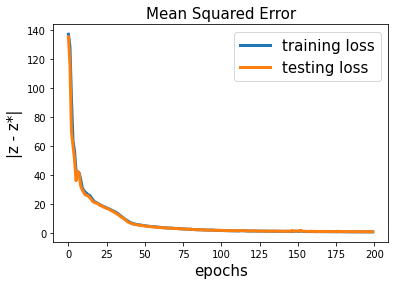

In [ ]:
# ---------------------------------------------
# Plot testing history
# ---------------------------------------------
import matplotlib.pyplot as plt

fig1 = plt.figure(1)
plt.plot(train_loss_hist, linewidth=3)
plt.plot(test_loss_hist, linewidth=3)
plt.legend(['training loss', 'testing loss'], fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('|z - z*|', fontsize=15)
plt.title('Mean Squared Error', fontsize=15)
plt.savefig('line_plot.pdf')  

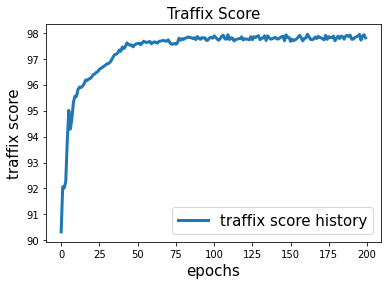

In [ ]:
fig1 = plt.figure(2)
plt.plot(traffix_score_hist, linewidth=3)
plt.legend(['traffix score history'], fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('traffix score', fontsize=15)
plt.title('Traffix Score', fontsize=15)
plt.savefig('traffix_score_plot.pdf')  

## Generate CSV File

In [ ]:
filename = data_set + '_epoch_vs_relerr.csv'
with open(filename, 'w') as f: 
  for epoch, rel_err in enumerate(rel_err_hist):     
    f.write('%0.5e,%0.5e\n' % (epoch + 1, rel_err)) 

filename = data_set + '_epoch_vs_trafix.csv'
with open(filename, 'w') as f: 
  for epoch, traffix_score in enumerate(traffix_score_hist):     
    f.write('%0.5e,%0.5e\n' % (epoch + 1, traffix_score)) 